In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
import matplotlib
from matplotlib import pyplot as plt
import psutil
import gc



print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


Globals

In [2]:
cwd = os.getcwd()
FREQ = 500
database_path = 'Dataset/CHB-MIT/chb-mit-scalp-eeg-database-1.0.0/'
filtered_database_path = 'Dataset/CHB-MIT/Filtered-chb-mit/'
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
edf_file_type = ".edf"
compressed_file_type = ".parquet.gzip"
file = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/patient_4_date_2019-05-21 1556430000.csv"


In [3]:
str_container = ""
with open("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/info.txt", 'r') as f:
    for line in f:
        str_container += str(line).replace("\n", "<br>")

        formatted_str = re.findall('(.*?)<br><br>', str_container)
        bla = [x.group() for x in re.finditer('(.*?)<br><br>', str_container)]
        for index, line in enumerate(formatted_str):
            if re.match('(^Channels in EDF Files:|^Channels changed:)', line):
                formatted_str.remove(formatted_str[index])
            else:
                pass

In [4]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe

In [5]:
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge'

In [6]:
for f in os.listdir("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG"):
    print(f)

.DS_Store
patient_4_date_2019-05-21 1556430000.csv
info.txt


In [7]:
df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/patient_4_date_2019-05-20 1102590000.csv", usecols=[1,2,3])

In [8]:
df.columns

Index(['class', 'timestamp', 'ECG'], dtype='object')

In [9]:
gc.collect()

30

In [10]:
# print(test_df.info(memory_usage='deep'))
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [11]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88161500 entries, 0 to 88161499
Columns: 3 entries, class to ECG
dtypes: float64(2), object(1)
memory usage: 6.8 GB


In [12]:
mem_usage(df)

'6969.98 MB'

In [13]:
df.dtypes

class         object
timestamp    float64
ECG          float64
dtype: object

In [14]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved_time = (_start - _end) / _start * 100
    #print(f"Saved: {saved_time:.2f}%")
    return df

In [15]:
df = downcast_dtypes(df)

In [16]:
df['class'].value_counts()

Interictal    83860000
Preictal       4050000
seizure         251500
Name: class, dtype: int64

In [17]:
def read_compressed_df(df):

    sz_df = df.loc[df['class'] == "seizure"]

    prei_one_df = df.loc[df['class'] == "Preictal"]

    inter_df = df.loc[df['class'] == "Interictal"]

    channels = [item for item in list(sz_df.columns) if item != "class" if item != "timestamp"]

    return (sz_df, prei_one_df, inter_df, channels)

In [18]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 500):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    date_timestamp = ""

    try:
        date_timestamp = datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')
    except:
        date_timestamp = "datetime cannot be converted"
    
    return [data[channel][start:end].tolist(), date_timestamp]

In [19]:
def get_max_window_iteration(dataframe, buffer, overlap=0):
    len_of_df = int(len(dataframe) / (buffer*FREQ)) + overlap
    return len_of_df


In [20]:
from scipy import signal

In [21]:
Fs = 500             # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = Fs * 0.95  # ... and the overlap intervals

def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win[0]
    time_of_observation = win[1]
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state} : {time_of_observation}")
    

    f, t, Sxx = signal.spectrogram(denoised_series, fs=Fs, nperseg=interval, noverlap=overlap)
                         
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')



    #s,f,t,im = plt.specgram(denoised_series,Fs=256)
    #plt.ylim(0, 20)
    #plt.axis('off')
    
    # f, t, Sxx = signal.spectrogram(denoised_series, 1./FREQ, nfft=overlap, nperseg=int(256/2))
    # #plt.pcolormesh(t, f[0:20], Sxx[0:20])
    # plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.show()
    # if patient_state == "seizure":
    #     plt.savefig(f'test_data//windows/Seizure2/{patient}_{index}_{channel}_{time_of_observation}.png', edgecolor='none', bbox_inches='tight')
    # elif patient_state == "interictal":
    #     plt.savefig(f'test_data//windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    # elif patient_state == "prei_one":
    #     plt.savefig(f'test_data//windows/test/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # elif patient_state == "prei_two":
    #     plt.savefig(f'test_data/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # plt.show()
    del series
    plt.clf()    
    plt.close()
    gc.collect()

In [22]:
count = 0

print("started file: " + str(file) + " index: " + str(count))
sz, prei_one, inter, selected_channels = read_compressed_df(df)
print(selected_channels)
print(f"len sz {len(sz)}")
print(f"len prei {len(prei_one)}")
patient = re.search('NHR/EEG/patient_(.*)_date_', file).group(1)
print(patient)
sz_count = 0
int_count = 0
count = 0
sz_win = []
inter_win =[]
for channel in selected_channels:
    if count < 1:
        if len(inter) > 0 and inter.empty == False and int_count < 3:
            inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
            # for index, window in enumerate(inter_win):
            #     if int_count > 1:continue
            #     spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient, plot_title=True)
            #     int_count += 1
            

        if len(sz) > 0 and sz.empty == False and sz_count < 3:
            sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
            # for index, window in enumerate(sz_win):
            #     if sz_count > 1:continue
            #     sz_count += 1
            #     spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient, plot_title=True)
            
        count += 1


del sz, prei_one, inter, df

started file: /Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/patient_4_date_2019-05-21 1556430000.csv index: 0
['ECG']
len sz 251500
len prei 4050000
4


In [24]:

gc.collect()

0

In [25]:
sz = sz_win[10][0]
inte = inter_win[25][0]

In [ ]:
time = np.arange(len(inte))/500

In [ ]:
nyquist = 500 / 2.
b, a = signal.filter_design.iirfilter(3, (120. / nyquist, 121. / nyquist), rs=10,
                               ftype='cheby2')

In [ ]:
xfilt = signal.filtfilt(b, a, sz)

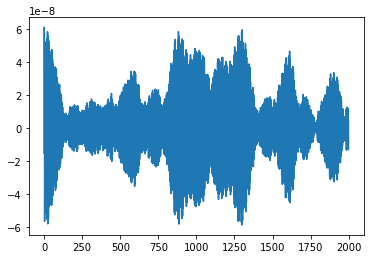

In [ ]:
plt.plot(xfilt)

In [ ]:
win = 4 * 256
f, psd = signal.welch(sz,
               fs=1./256,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean

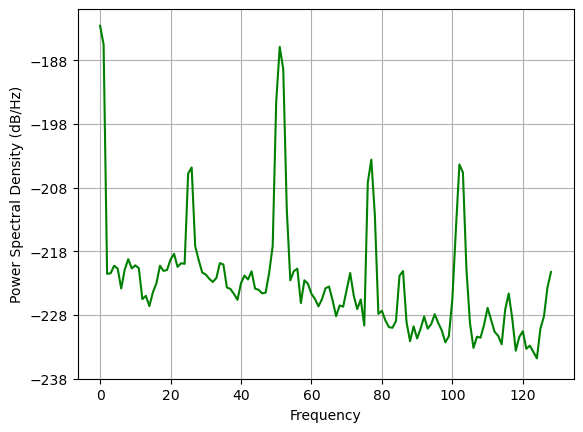

In [ ]:
plt.style.use('default')
plt.psd(np.array(sz)**2, Fs=256, color ="green")
lines = plt.gca().get_lines()
x_data = lines[0].get_data()[1]

In [ ]:
den_sz = denoise_wavelet(np.array(sz).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db8', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)

In [ ]:
Fs = 256         # Define the sampling frequency,
interval = 256       # ... the interval size,
overlap = interval * 0.99  # ... and the overlap intervals

/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


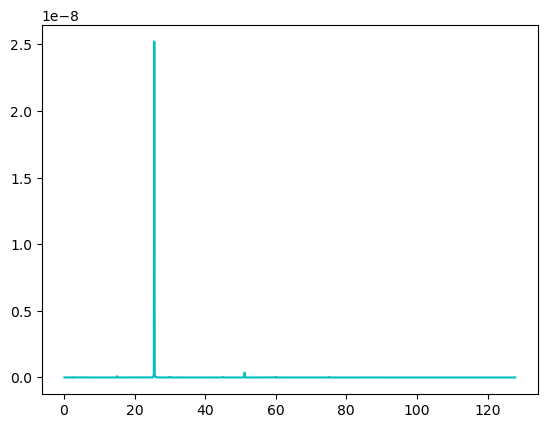

In [ ]:
dt = 1/256
n = len(inte)
fhat = np.fft.fft(inte, n)
PSD = fhat * np.conj(fhat / n)
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

plt.plot(freq[L], PSD[L], color='c')

NameError: name 'den_inte' is not defined

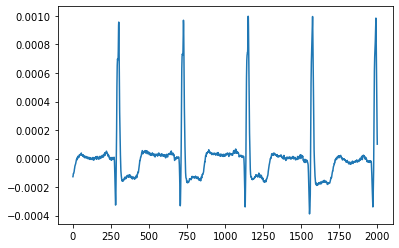

In [26]:
plt.plot(inte)
plt.plot(den_inte)

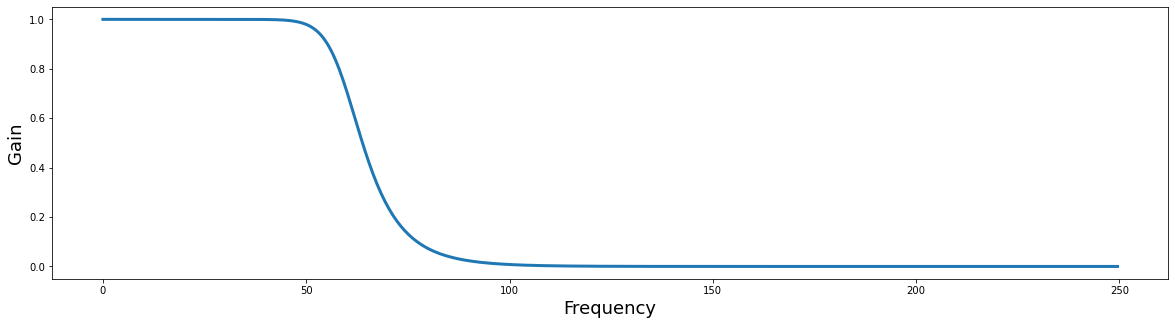

In [27]:
filter_order = 8
frequency_cutoff = 60
sampling_frequency = 500

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

# Create the filter
b, a = signal.butter(filter_order, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)
plot_filter(b, a, sampling_frequency)

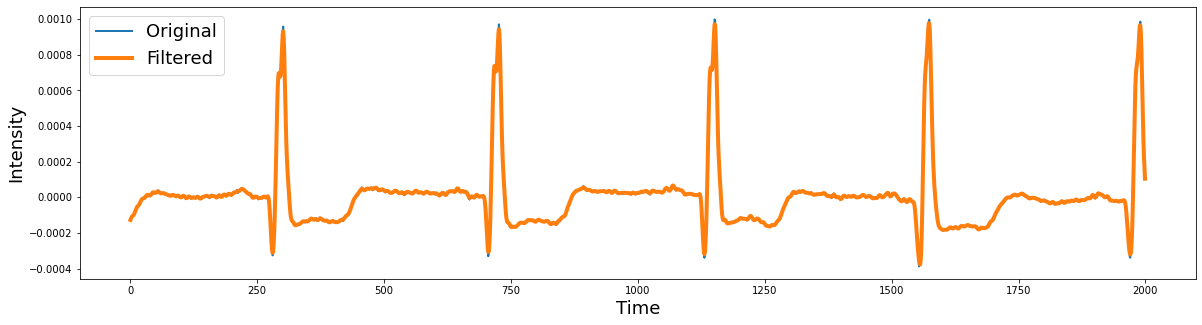

In [28]:
# Apply the filter
filtered_int = signal.filtfilt(b, a, inte)
filtered_sz = signal.filtfilt(b, a, sz)

plt.figure(figsize=(20,5))
plt.plot(inte, linewidth=2)
plt.plot(filtered_int, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

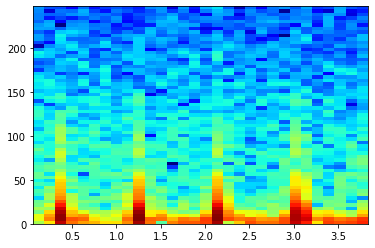

In [30]:
s,f,t,im = plt.specgram(sz,Fs=500,cmap='jet', NFFT=int(FREQ/4), noverlap=int(FREQ/8))

In [36]:
Fs = 500       # Define the sampling frequency,
interval = 500   # ... the interval size,
overlap = interval * 0.95  # ... and the overlap intervals

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_5790/142312461.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result


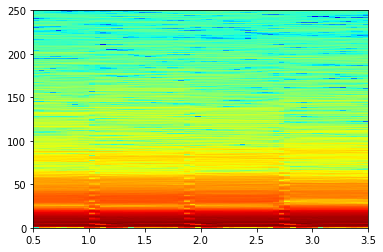

In [37]:
import matplotlib
import pylab
import matplotlib.colors as colors
from scipy.stats import lognorm

f, t, Sxx = signal.spectrogram(np.array(inte), fs=Fs, nperseg=interval, noverlap=overlap)

normalize_color= colors.LogNorm(vmin=np.amin(Sxx), vmax=np.amax(Sxx))
plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result
#plt.savefig("hi2.png")


/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_4855/2612149833.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result


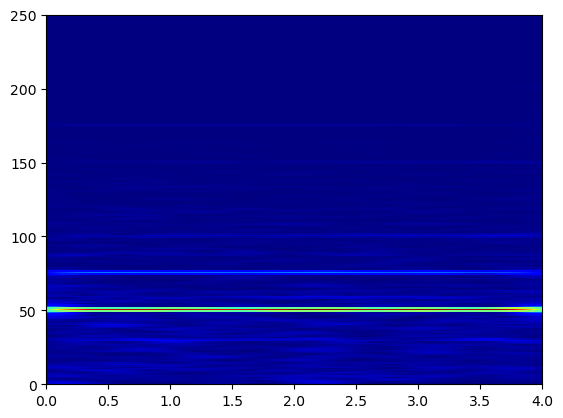

In [ ]:
f, t, Zxx = signal.stft(den_inte, fs=Fs, nperseg=FREQ, noverlap=FREQ*0.99)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result

(array([[5.49003766e-14, 2.08523249e-15, 5.19470508e-15, ...,
         3.32670532e-15, 7.69669873e-16, 2.34051345e-16],
        [5.92613998e-14, 1.42018500e-14, 8.11503575e-15, ...,
         1.33686458e-14, 4.79594557e-15, 1.24976894e-15],
        [5.00652147e-14, 2.11405356e-14, 2.58543052e-15, ...,
         6.25268038e-14, 8.65616222e-15, 3.67517278e-15],
        ...,
        [2.99151731e-25, 9.61646787e-26, 5.48177472e-27, ...,
         2.15754452e-27, 1.37841985e-26, 7.33300049e-28],
        [2.95042306e-25, 9.27798149e-26, 1.62773015e-27, ...,
         1.06421262e-27, 1.25866358e-26, 5.68541878e-28],
        [1.46839610e-25, 4.58289915e-26, 1.74032386e-28, ...,
         3.51331300e-28, 6.09537569e-27, 2.58763475e-28]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,

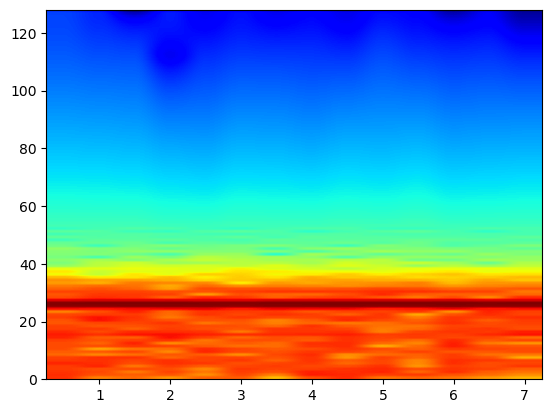

In [ ]:
plt.specgram(filtered_int, cmap='jet', Fs=256)
#plt.savefig("hi.png")

In [ ]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

In [ ]:
fs=256
lowcut=117
highcut=123
y=butter_bandstop_filter(den_sz, lowcut, highcut, fs, order=6)

lowcut=57
highcut=63
y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)

In [ ]:
freqs, bins,Pxx =signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=256*0.95)

In [ ]:
Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
Pxx = np.delete(Pxx, 0, axis=0)

In [ ]:
freqs = np.arange(Pxx.shape[0])

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_4855/1495177456.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)


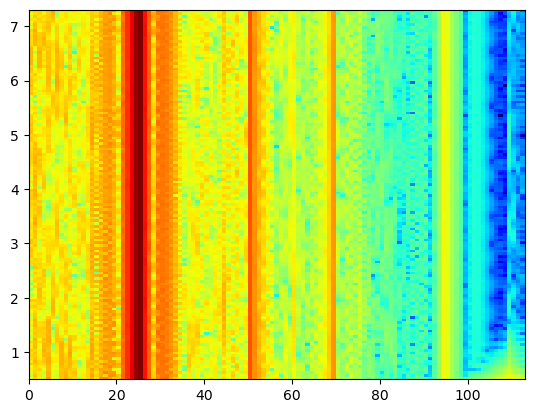

In [ ]:
plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)

In [ ]:
result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_4855/42712137.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)


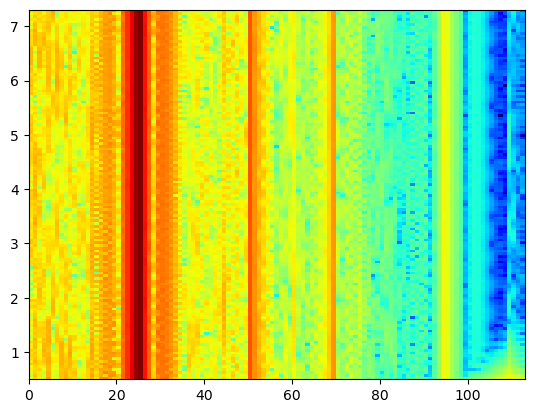

In [ ]:
freqs = np.arange(result.shape[1])
plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)

In [ ]:
plt.style.use('default')
plt.specgram(filtered, Fs=256, NFFT=128, noverlap=256/8, cmap='jet')


NameError: name 'filtered' is not defined

In [ ]:
datetime.fromtimestamp(-2208984384000/1000).strftime('%H:%M:%S')

'02:13:36'

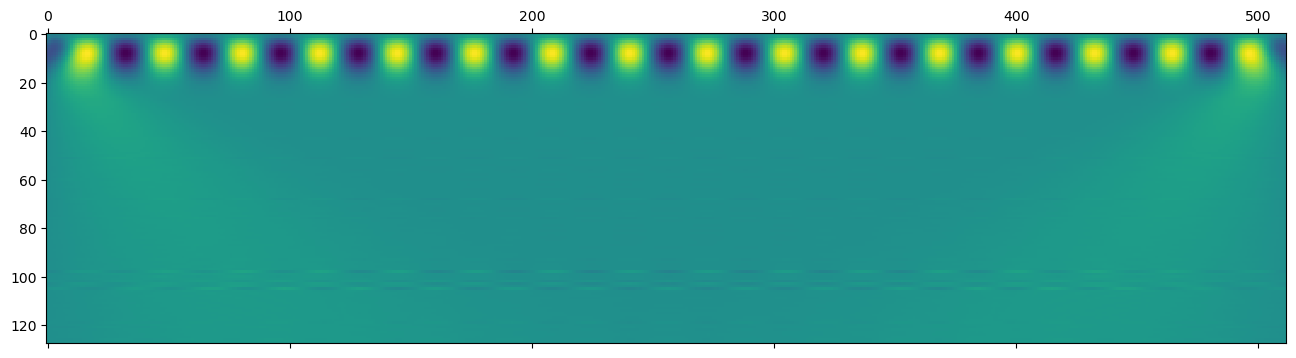

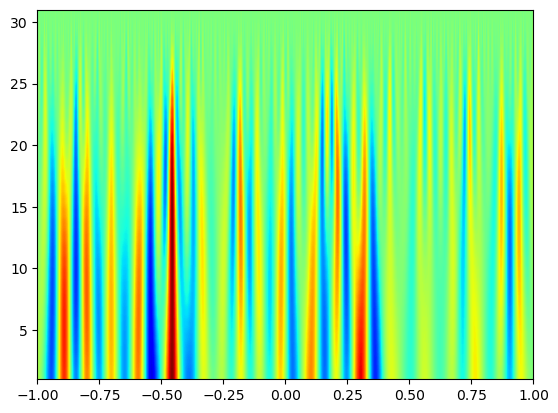

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP

import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(inte, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP